In [1]:
import tensorflow as tf
import tensorflow.feature_column as fc 

import os
import sys
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

#tf.enable_eager_execution()

# For output stability across multiple runs of the notebook
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print(sys.executable)

def shuffle_batch(X, batch_size):
    # Shuffle the indices
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    
    # Split the index array into the number of batches
    # Get the list of indexs per batch
    # and yield the values when asked
    for batch_idxs in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idxs]
        yield X_batch

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

tf.__version__

/Users/Work/anaconda3/envs/condaflow/bin/python


'1.13.1'

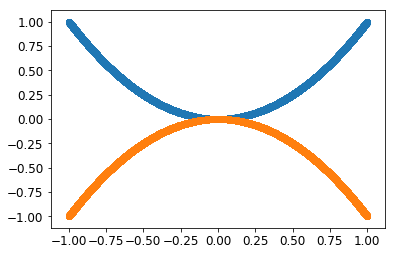

In [2]:
# Funcs to generate data
def y(x,sign=1):
    return x*x

# Data ranging from x = -0.5 to 0.5
def sample_data(n=10000, scale=100):
    data1 = []
    data2 = []
    
    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = y(x[i])
        y2i = -yi
        data1.append([x[i], yi])
        data2.append([x[i], y2i])
        
    return np.float32(np.array(data1)), np.float32(np.array(data2))


X1, X2 = sample_data(n=20000,scale=2)
train_data = np.concatenate([X1,X2],axis=1)
plt.scatter(X1[:,0], X1[:,1])
# plt.show()
plt.scatter(X2[:,0], X2[:,1])

In [35]:
from model import RoboGAN

reset_graph()

sess = tf.Session()

nDimX = X1.shape[1]
nDimY = X2.shape[1]

GAN = RoboGAN()

# Generating forward GAN = G: X -> Y
X = tf.placeholder(tf.float32, shape=(None,nDimX), name = "X")
G = GAN.generator(name="G")
G_D = GAN.discriminator(name="G_D")

# Generating backward GAN = F: Y -> X
Y = tf.placeholder(tf.float32, shape=(None, nDimY), name="Y")
F = GAN.generator(name="F")
F_D = GAN.discriminator(name="F_D")


In [36]:
# Loss for
with tf.GradientTape() as G_tape,   \
     tf.GradientTape() as G_D_tape, \
     tf.GradientTape() as F_tape,   \
     tf.GradientTape() as F_D_tape:
    
    # Generating forward samples X -> Y
    fake_Y = G(X)
    D_Gy_logits = G_D(fake_Y)
    D_Y_logits = G_D(Y)
    
    # Generating backward samples X <- Y
    fake_X = F(Y)
    D_Fx_logits = F_D(fake_X) # D_Fx = D_X ( F(Y) )
    D_X_logits = F_D(X)
    
    cycle_loss = GAN.cycle_consistency_loss(G_Fx= G(fake_X), F_Gy= F(fake_Y), x= X, y= Y)
    
    G_loss = GAN.generator_loss(D_Gy_logits, heuristic=False) + cycle_loss
    G_D_loss = GAN.discriminator_loss(real_output= D_Y_logits, fake_output= D_Gy_logits)
    
    F_loss = GAN.generator_loss(D_Fx_logits, heuristic=False) + cycle_loss
    F_D_loss = GAN.discriminator_loss(real_output= D_X_logits, fake_output= D_Fx_logits)
    
    G_gradients = G_tape.gradient(G_loss, G.trainable_variables)
    G_D_gradients = G_D_tape.gradient(G_D_loss, G_D.trainable_variables)
    
    F_gradients = F_tape.gradient(F_loss, F.trainable_variables)
    F_D_gradients = F_D_tape.gradient(F_D_loss, F_D.trainable_variables)

## Setting up optimizers

In [37]:
opt_G = tf.train.AdamOptimizer(1e-3)
opt_G_D = tf.train.AdamOptimizer(1e-3)
opt_F = tf.train.AdamOptimizer(1e-3)
opt_F_D = tf.train.AdamOptimizer(1e-3)

train_G = opt_G.apply_gradients(zip(G_gradients, G.trainable_variables))
train_F = opt_F.apply_gradients(zip(F_gradients, F.trainable_variables))

train_D_X = opt_G_D.apply_gradients(zip(G_D_gradients, G_D.trainable_variables))
train_D_Y = opt_F_D.apply_gradients(zip(F_D_gradients, F_D.trainable_variables))

## Running the training via a tensorflow session
> Generators will be trained first

In [42]:
sess =  tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 100
for epoch in range(15):
    for i,batch in enumerate(shuffle_batch(train_data, batch_size)):
        X_batch = batch[:,:nDimX]
        Y_batch = batch[:,nDimX:]
        
        
        # Training Generators G and F first w/ cycle consistency
        Gloss, Floss, _,_ = sess.run([G_loss, F_loss, train_G, train_F],
                                     feed_dict={X:X_batch, Y:Y_batch})
        
        # Optimizing Discriminators D_X and D_Y
        D_Xloss, D_Yloss, _,_ = sess.run([G_D_loss, F_D_loss, train_D_X, train_D_Y],
                                         feed_dict={X: X_batch, Y: Y_batch})

    
    print("Epoch {}: GLoss:{:.4f}, FLoss:{:.4f}, DXLoss:{:.4f}, DYLoss:{:.4f}".format(epoch,Gloss,Floss,D_Xloss,D_Yloss))

Epoch 0: GLoss:1.1845, FLoss:1.1866, DXLoss:0.6751, DYLoss:0.6607
Epoch 1: GLoss:0.9922, FLoss:1.0250, DXLoss:0.6906, DYLoss:0.6796
Epoch 2: GLoss:0.9029, FLoss:0.9254, DXLoss:0.6868, DYLoss:0.6754
Epoch 3: GLoss:0.9312, FLoss:0.9397, DXLoss:0.6795, DYLoss:0.6719
Epoch 4: GLoss:0.8879, FLoss:0.8764, DXLoss:0.6902, DYLoss:0.6895
Epoch 5: GLoss:0.8463, FLoss:0.8418, DXLoss:0.6916, DYLoss:0.6901
Epoch 6: GLoss:0.8240, FLoss:0.8528, DXLoss:0.6895, DYLoss:0.6867
Epoch 7: GLoss:0.8103, FLoss:0.7956, DXLoss:0.6924, DYLoss:0.6905
Epoch 8: GLoss:0.7725, FLoss:0.7945, DXLoss:0.6902, DYLoss:0.6889
Epoch 9: GLoss:0.7747, FLoss:0.7833, DXLoss:0.6920, DYLoss:0.6922
Epoch 10: GLoss:0.7979, FLoss:0.7989, DXLoss:0.6902, DYLoss:0.6856
Epoch 11: GLoss:0.7637, FLoss:0.7700, DXLoss:0.6911, DYLoss:0.6884
Epoch 12: GLoss:0.7716, FLoss:0.7653, DXLoss:0.6918, DYLoss:0.6872
Epoch 13: GLoss:0.7647, FLoss:0.7602, DXLoss:0.6918, DYLoss:0.6892
Epoch 14: GLoss:0.7696, FLoss:0.7823, DXLoss:0.6918, DYLoss:0.6891


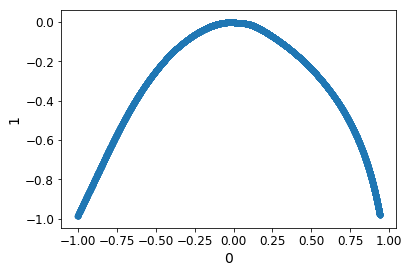

In [43]:
a=sess.run([fake_Y], feed_dict={X:X1})
temp=pd.DataFrame(a[0])
temp.plot.scatter(x=0, y=1)

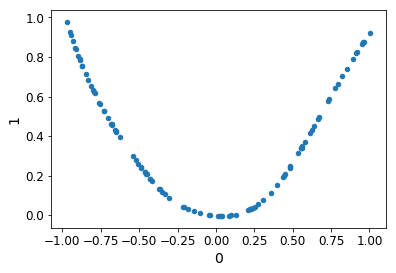

In [44]:
b=sess.run([fake_X], feed_dict={Y:X2[:100]})
temp2=pd.DataFrame(b[0])
temp2.plot.scatter(x=0, y=1)

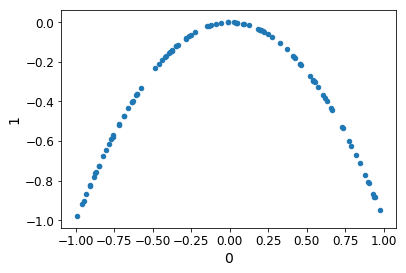

In [41]:
pd.DataFrame(X2[:100]).plot.scatter(x=0,y=1)